# Bitcoin Network Ratios
Author: [@typerbole](https://twitter.com/typerbole), [GitHub](https://github.com/ty-perbole), [stack-stats.com](http://www.stack-stats.com)

This notebook provides an introduction to calculating and understanding Bitcoin network ratios using data freely available via [CoinMetrics](https://coinmetrics.io). My goal is to develop a better understanding of these metrics by deriving them myself, as I learn best this way, and to provide the end product as a learning resource for others who want the same experience. This is the first notebook of a series I plan to release on GitHub via the [Stack Stats](http://www.stack-stats.com) repository.

Most of the ratios explored in this notebook are primarily used as market timing indicators with the goal of identifying periods of over and under-valuation for BTC. While this is a fun exercise to understand market dynamics **I do not recommend trying to time the market and trade on these ratios**.

I was introduced to most of the work discussed in this notebook via [Willy Woo’s website](http://charts.woobull.com/), which I recommend for those interested in further analysis. I also highly recommend CoinMetrics’ [Cryptoasset Valuation Research Primer](https://coinmetrics.io/coin-metrics-state-of-the-network-issue-40-cryptoasset-valuation-research-primer-part-2/) for a comprehensive history of work in this space.

See the [Stack Stats readme](https://github.com/ty-perbole/stack-stats/blob/master/README.md) for more about this project and further instructions in how to run the jupyter notebook.

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import chart_utils

In [2]:
# try:
#     os.remove("btc.csv")
# except FileNotFoundError:
#     pass
# !wget https://coinmetrics.io/newdata/btc.csv

In [3]:
data = pd.read_csv("btc.csv",
                   usecols=['date', 'CapMrktCurUSD', 'CapRealUSD', 'TxTfrValAdjUSD', 'PriceUSD']).dropna()
data.columns.values

array(['date', 'CapMrktCurUSD', 'CapRealUSD', 'PriceUSD',
       'TxTfrValAdjUSD'], dtype=object)

# Column descriptions
Source: https://coinmetrics.io/tools/

The CoinMetrics community data dump contains many useful pre-computed columns, including their versions of some of the ratios we will be calculating. We’re going to ignore most columns in the .csv for this exercise and derive all ratios from the following four data series, which serve as the building blocks for all our ratios.

**CapMrktCurUSD**: "The sum USD value of the current supply. Also referred to as network value or market capitalization."

**CapRealUSD:** "The sum USD value based on the USD closing price on the day that a native unit last moved (i.e., last transacted) for all native units."

**TxTfrValAdjUSD**: "The USD value of the sum of native units transferred between distinct addresses that interval removing noise and certain artifacts."

**PriceUSD**: "The fixed closing price of the asset as of 00:00 UTC the following day (i.e., midnight UTC of the current day) for end-of-day data or the closest prior hour (nearest to that block) for block-by-block data, denominated in USD."

# 1. NVT Ratio (NVT)
Credit: [Willy Woo](https://twitter.com/woonomic), [Woobull dashboard](http://charts.woobull.com/bitcoin-nvt-ratio/)

## ${Network\ Value\ to\ Transactions\ Ratio\ (NVT)_t}=\frac{Market\ Cap\ (USD)_t}{Daily\ On-Chain\ Transaction\ Volume\ (USD)_t}$

NVT ratio was devised by Willy Woo in 2017 and serves as the forebear for many of the other metrics explored in this notebook. It is analogous to P/E ratio for equities, where on-chain transaction volume takes the place of earnings in the denominator. In Woo's own words: "When Bitcoin`s NVT is high, it indicates that its network valuation is outstripping the value being transmitted on its payment network, this can happen when the network is in high growth and investors are valuing it as a high return investment, or alternatively when the price is in an unsustainable bubble."

Below, we will create a column in our dataframe for NVTRatio and plot this series against BTC price. 

I provide a charting utility that serves as an interface for the Plotly library with some sane defaults for our use case. Most charts in this notebook will plot the BTC/USD price on the right axis in log scale for comparison against our ratios. Please see the docstrings in [chart_utils.py](https://github.com/ty-perbole/stack-stats/blob/master/chart_utils.py) for more detail on these utilities.

In [4]:
# We use TxTfrValAdjUSD for transaction volume, which adjusts for obvious change UTXOs
# and UTXOs spent within 4 blocks of the inputs.
# See: https://coinmetrics.io/introducing-adjusted-estimates/
data['NVTRatioAdj'] = data['CapMrktCurUSD'] / data['TxTfrValAdjUSD']

chart_utils.two_axis_chart(
    data, x_series='date', y1_series='NVTRatioAdj', y2_series='PriceUSD',
    title='NVTRatioAdj', 
    y1_series_axis_type='log', y1_series_axis_range=[1, 3], # Axis range is an exponent, so 1 means 10**1, 2 means 10**2 etc.
    y2_series_axis_type='log', y2_series_axis_range=[-2, 6])

FigureWidget({
    'data': [{'name': 'NVTRatioAdj',
              'type': 'scatter',
              'uid': 'f6a…

Although this chart is noisy you can make out clear longer-term oscillations in the data. One technique that can help reduce noise in our data series is a [rolling average](https://www.investopedia.com/terms/m/movingaverage.asp). This smooths out the time series but also reduces responsiveness and causes the data series to lag underlying movements.

Below we plot NVT with 7, 14, 28 and 70 day rolling averages. For rolling averages, I prefer to use window sizes divisible by 7 so that any period contains full-week periods and smooths out day-of-the-week effects. You can click the data series in the legend to the right of the plot to disable / re-enable different series and see how the window size impacts the rolling average.

In [5]:
window_sizes = [7, 14, 28, 56, 70]
y1_series = []
for window_size in window_sizes:
    data['NVTRatioAdjRoll{}'.format(window_size)] = data['NVTRatioAdj'].rolling(window_size).mean()
    y1_series.append('NVTRatioAdjRoll{}'.format(window_size))

# Here we pass a list (y1_series) of columns we want to plot on the left Y axis
chart_utils.two_axis_chart(
    data, x_series='date', y1_series=y1_series, y2_series='PriceUSD',
    y1_series_axis_type='log', y1_series_axis_range=[1, 3],
    y2_series_axis_type='log', y2_series_axis_range=[-2, 6])

FigureWidget({
    'data': [{'name': 'NVTRatioAdjRoll7',
              'type': 'scatter',
              'uid':…

We have successfully reduced noise in our plot but we have another problem: it doesn't look like the peaks in NVT line up well with BTC price peaks. For the next metric, NVT Signal, we will introduce a correction that helps align the metric with market peaks.

### Pros
- First metric of this type
- Relates valuation to on-chain usage
- Concepts work across different blockchains

### Cons
- Market cap is easily manipulated on blockchains where a significant fraction of supply is centralized or tied-up
- Transaction volume is also game-able, especially when transaction fees are artifically low. This can be partially controlled by using [adjusted transaction volume from CoinMetrics](https://coinmetrics.io/introducing-adjusted-estimates/) (TxTfrValAdjUSD)
- Transaction volume does not include off-chain or layer two activity, such as custodial exchanges, liquid and lightning.
- Peaks in NVT lag bubble peaks by months

# 2. NVT Signal Ratio (NVTS)
Credit: [Dmitry Kalichkin](https://twitter.com/Kalichkin), [Medium Article](https://medium.com/cryptolab/https-medium-com-kalichkin-rethinking-nvt-ratio-2cf810df0ab0)

## ${NVT\ Signal\ Ratio\ (NVTS)_t}=\frac{Market\ Cap\ (USD)_t}{\frac{1}{N} * \sum_{n=t}^{t-N}Daily\ On-Chain\ Transaction\ Volume\ (USD)_n}$
*Note: N is rolling average window size.*

Building on the concept of the original NVT ratio from above, Dmitry Kalichkin had the insight that applying a rolling average to the transaction volume component in the denominator of the ratio would smooth the metric while allowing market cap in the numerator to move day-to-day and enable metric responsiveness in real time.

In the original formulation, Kalichkin found that a 90 day rolling average gave best results. Since we are calculating this for ourselves we can test out a few different window sizes for the rolling average window, plot them all on the same chart and see how window size impacts the time series.

In [6]:
window_sizes = [7, 14, 28, 56, 70, 90, 140]
y1_series = []
for window_size in window_sizes:
    data['NVTSRatioRoll{}'.format(window_size)] = data['CapMrktCurUSD'] / data['TxTfrValAdjUSD'].rolling(window_size).mean()
    y1_series.append('NVTSRatioRoll{}'.format(window_size))

chart_utils.two_axis_chart(
    data, x_series='date', y1_series=y1_series, y2_series='PriceUSD',
    y1_series_axis_type='log', y1_series_axis_range=[1, 3],
    y2_series_axis_type='log', y2_series_axis_range=[-2, 6])

FigureWidget({
    'data': [{'name': 'NVTSRatioRoll7',
              'type': 'scatter',
              'uid': '…

De-select all NVTS metrics from displaying using the legend to the right, then enable each one at a time to see how the window size impacts responsiveness. You may notice that window lengths starting 56 days and longer show more pronounced peaks coinciding with market tops. The original choice of a 90 day moving average seems sensible.

Let's generate some thresholds to highlight market tops and bottoms. Using the NVTSRatioRoll90 data series, we can calculate the 10th and 90th percentile values for NVTS, and use these as thresholds to warn when this ratio is approaching extreme values. We will ignore data prior to 2013 when calculating our percentiles, to throw out the highly volatile early period of Bitcoin network growth. 

The below chart highlights regions with low NVTS in green, representing good value, and regions with high NVTS in red, representing valuation outpacing fundamentals.

In [7]:
metric_name = 'NVTSRatioRoll90'

chart_utils.two_axis_chart(
    data, x_series='date', y1_series=metric_name, y2_series='PriceUSD',
    y1_series_axis_type='log', y1_series_axis_range=[1, 3],
    # Feel free to set these thresholds to any value you think may work better than the 10th/90th percentile
    y1_upper_thresh=np.percentile(data.loc[data['date'] >= '2013-01-01'][metric_name].dropna(), 90),
    y1_lower_thresh=np.percentile(data.loc[data['date'] >= '2013-01-01'][metric_name].dropna(), 10),
    y2_series_axis_type='log', y2_series_axis_range=[-2, 6])

FigureWidget({
    'data': [{'name': 'NVTSRatioRoll90',
              'type': 'scatter',
              'uid': …

It looks like NVTS has more trouble spotting local price minima than maxima.

You also might notice that the period prior to June 2011 is highlighted red, indicating a bad time to buy Bitcoin. Obviously you would have wanted to buy Bitcoin at < $1 despite NVTS indicating over-valuation (relative to usage). This brings up a potential pitfall of these ratios and thresholds: the network and market dynamics of Bitcoin were different during this time of incipient usage, which may make ratios developed using data from a more recent period with a different dynamic invalid. This same disclaimer applies to the future where there will likely be another secular shift in Bitcoin usage that could obsolete signals developed during this period.

Additionally, the thresholds were generated using a small handful of market cycles, so there is a high likelihood that the thresholds are over-fit on this small sample size.

### Pros
- NVTS responds to market dynamics in real time
- Seems to accurately spot market tops

### Cons
- Doesn’t seem to identify bottoms well
- All caveats about limitations of market cap and transaction volume mentioned for NVT still apply

# 3. Realized Cap to Transaction Ratio (RVT)
Credit: [Checkmate](https://twitter.com/_Checkmatey_), [Medium Article](https://medium.com/@_Checkmatey_/the-bitcoin-rvt-ratio-a-high-conviction-macro-indicator-615b68715b77)

Extending from NVT, we can calculate a version of NVT that uses Realized Cap from CoinMetrics in the numerator instead of Market Cap. Realized cap is a Market Cap analogue that values each UTXO at the price when it was last moved on-chain, rather than the current price. It typically lags Market Cap and is roughly an estimate of the cost basis of all Bitcoin hodlers. See more [here](https://coinmetrics.io/realized-capitalization/).

## ${Realized\ Cap\ to\ Transaction\ Ratio\ (RVT)_t}=\frac{Realized\ Cap\ (USD)_t}{\frac{1}{N} * \sum_{n=t}^{t-N}Daily\ On-Chain\ Transaction\ Volume\ (USD)_n}$

In [8]:
window_sizes = [7, 14, 28, 56, 70, 90, 140]
y1_series = []
for window_size in window_sizes:
    data['RVTRatioRoll{}'.format(window_size)] = data['CapRealUSD'] / data['TxTfrValAdjUSD'].rolling(window_size).mean()
    y1_series.append('RVTRatioRoll{}'.format(window_size))

chart_utils.two_axis_chart(
    data, x_series='date', y1_series=y1_series, y2_series='PriceUSD',
    y1_series_axis_type='log', y1_series_axis_range=[0, 3],
    y2_series_axis_type='log', y2_series_axis_range=[-2, 6])

FigureWidget({
    'data': [{'name': 'RVTRatioRoll7',
              'type': 'scatter',
              'uid': '5…

I like the 28 day moving average for this series, which is also what Checkmate uses in the original formulation.

In [9]:
metric_name = 'RVTRatioRoll28'

chart_utils.two_axis_chart(
    data, x_series='date', y1_series=metric_name, y2_series='PriceUSD',
    y1_series_axis_type='log', y1_series_axis_range=[0, 3],
    y1_upper_thresh=np.percentile(data.loc[data['date'] >= '2013-01-01'][metric_name].dropna(), 90),
    y1_lower_thresh=np.percentile(data.loc[data['date'] >= '2013-01-01'][metric_name].dropna(), 10),
    thresh_inverse=True,
    y2_series_axis_type='log', y2_series_axis_range=[-2, 6])

FigureWidget({
    'data': [{'name': 'RVTRatioRoll28',
              'type': 'scatter',
              'uid': '…

Interestingly, RVT behaves inversely (note use of thresh_inverse=True in charting function) to NVT(S). For NVT, high values indicate poor fundamentals relative to price (and thus poor time periods to buy), while RVT peaks around market bottoms and experiences lows near the tops. 

One possible explanation for the inverse behavior: at the nadir of a bear market most investors have overpaid for BTC (high realized cap) and inflows dry up due to investor losses; this leads to a period of low on-chain activity (low transaction volume) which creates the setup for peak RVT. RVT starts to increase out of this bottom when underwater investors capitulate and sell their coins to new investors at a lower cost basis, reducing the ratio numerator.

### Pros
- RVT controls for limitations of Market Cap by using Realized Cap
- Better at spotting bottoms than NVT(S). RVT peaks when aggregate investor’s cost basis is highest relative to market activity.

### Cons
- Low values of RVT, which should indicate market tops, precede market tops by months. This can be a signal that a new bull market has started, but will not tell you much about when it will end.

# 4. Market Value to Realized Value Ratio (MVRV)
Credit: [Murad Mahmudov](https://twitter.com/MustStopMurad), [David Puell](https://twitter.com/kenoshaking)

## ${Market\ Value\ to\ Realized\ Value\ (MVRV)_t}=\frac{Market\ Cap\ (USD)_t}{Realized\ Cap\ (USD)_t}$

If realized cap generally tracks the cost basis for BTC hodlers and market cap tracks these same UTXOs marked to market, then taking the ratio of market cap to realized cap will yield the approximate gains/losses of BTC hodlers in aggregate. 

When MVRV is > 1, the majority of UTXO on-chain have appreciated in value, which can represent a period of accelerated price appreciation and bullish sentiment. Likewise, when MVRV < 1, UTXOs are worth less than their cost basis, which signals a price crash.

In [10]:
metric_name = 'MVRV'

data[metric_name] = data['CapMrktCurUSD'] / data['CapRealUSD']

chart_utils.two_axis_chart(
    data, x_series='date', y1_series=metric_name, y2_series='PriceUSD',
    y1_series_axis_type='log', y1_series_axis_range=[-1, 1],
    y1_upper_thresh=np.percentile(data.loc[data['date'] >= '2013-01-01'][metric_name].dropna(), 90),
    y1_lower_thresh=np.percentile(data.loc[data['date'] >= '2013-01-01'][metric_name].dropna(), 10),
    y2_series_axis_type='log', y2_series_axis_range=[-2, 6])

FigureWidget({
    'data': [{'name': 'MVRV',
              'type': 'scatter',
              'uid': '307c97c7-a…

Any period where MVRV < 1 looks like a decent time to buy and likewise anytime MVRV > 4 coincides with market tops. As with all ratios explored here, metric thresholds are defined using the past distribution which includes only 2-3 full market cycles. No doubt these thresholds are over-fit and will have unreliable performance in the future, out of sample. 

Furthermore, using these ratios and thresholds is essentially a bet on mean reversion, and Bitcoin's mean state over time has been exponential price appreciation. If you follow a mean reversion strategy with these ratios your implicit assumption is that exponential appreciation with short-term market cycles will continue in the future. This is definitely not guaranteed, but if it plays out that way a substantial amount of value will be captured by simple buy and hold, ignoring short term market fluctuations.

### Pros
- Seemingly accounts for aspects of investor psychology and herd behavior which can drive market cycles
- Intuitive / easy to grok
- Does not use moving average, so no need to choose a moving average value, which can be overfit on past data

### Cons
- Same caveats around brittle thresholds and potential for secular shifts that apply to other ratios

# 5. Mayer Multiple
Credit: [Trace Mayer](https://twitter.com/tracemayer)

## ${Mayer\ Multiple_t}==\frac{BTC/USD\ Price_t}{\frac{1}{200} * \sum_{n=t}^{t-200}BTC/USD\ Price_n}$

Mayer Multiple is a well known and simple price ratio for Bitcoin that compares the current price to a 200 day moving average of the historical price. 

Unlike the ratios investigated earlier, Mayer Multiple is calculated solely from price data and does not attempt to incorporate any on-chain data inputs. This is an obvious blind spot, so Mayer Multiple should be used in conjunction with other signals, but it performs very well at identifying tops and bottoms.

In [11]:
metric_name = 'MayerMultiple'
data[metric_name] = data['PriceUSD'] / data['PriceUSD'].rolling(200).mean()

chart_utils.two_axis_chart(
    data, x_series='date', y1_series=metric_name, y2_series='PriceUSD',
    y1_series_axis_type='log', y1_series_axis_range=[-1, 2],
    y1_upper_thresh=np.percentile(data.loc[data['date'] >= '2013-01-01'][metric_name].dropna(), 90),
    y1_lower_thresh=np.percentile(data.loc[data['date'] >= '2013-01-01'][metric_name].dropna(), 10),
    y2_series_axis_type='log', y2_series_axis_range=[-2, 6])

FigureWidget({
    'data': [{'name': 'MayerMultiple',
              'type': 'scatter',
              'uid': '8…

You may notice that the Mayer Multiple seems to be getting less volatile over time - peaks are lower and bottoms are higher. We can see if this is true by computing a rolling standard deviation of the Mayer Multiple.

In [12]:
data['MayerMultipleStDev'] = data['MayerMultiple'].rolling(200).std()
chart_utils.two_axis_chart(
    data, x_series='date', y1_series=['MayerMultiple', 'MayerMultipleStDev'], y2_series='PriceUSD',
    y1_series_axis_type='log', y1_series_axis_range=[-2, 2],
    y2_series_axis_type='log', y2_series_axis_range=[-2, 6])

FigureWidget({
    'data': [{'name': 'MayerMultiple',
              'type': 'scatter',
              'uid': '8…

The standard deviation does appear to be trending down over time but has large discontinuities and generally jumps after the peak of a bull market.

### Pros
- Simple ratio based on a single data input: price
- Will not be impacted as transaction volume shifts off-chain to layer two

### Cons
- Does not account for network fundamentals
- As BTC matures Mayer Multiple appears to be getting less volatile, making it potentially harder to spot tops and bottoms.

# Current network state

Now that we have calculated our network ratios, let’s take a step back and see what they tell us about the current state of the network. To do this, we will plot histograms for each ratio to show the distribution of that ratio's values (post-2013) and where our current value lies in that distribution.

Additionally we will calculate a simple [Z-score](https://en.wikipedia.org/wiki/Standard_score) that you may remember from intro stats. The Z-score normalizes the given ratio value by subtracting the historical mean so that the new mean is zero, then dividing by the historical standard deviation to normalize the units to standard deviations above/below the mean. These Z-scores are only valid if the underlying distribution appears normally distributed, otherwise they are not well calibrated.

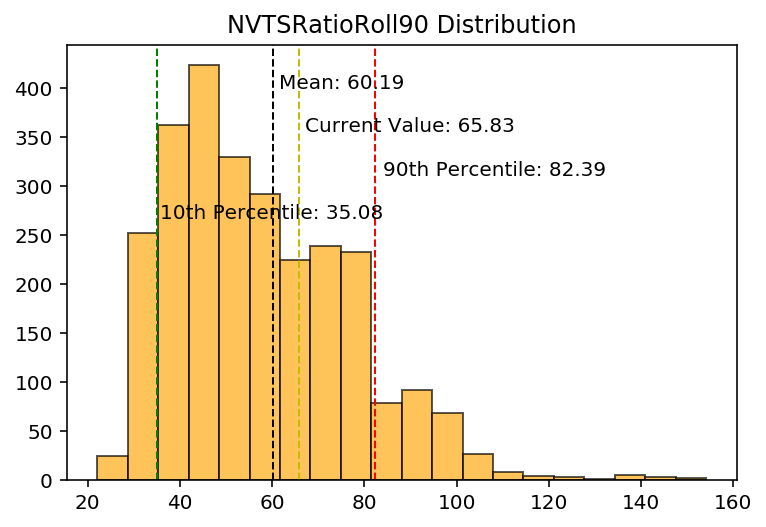

Current NVTSRatioRoll90 value is 65.83 and has a Z-Score of 0.17 compared to prior history


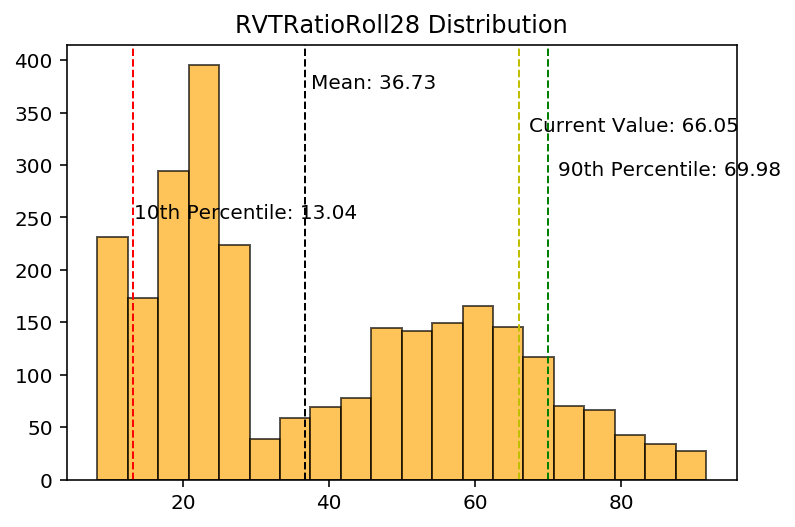

Current RVTRatioRoll28 value is 66.05 and has a Z-Score of 1.38 compared to prior history


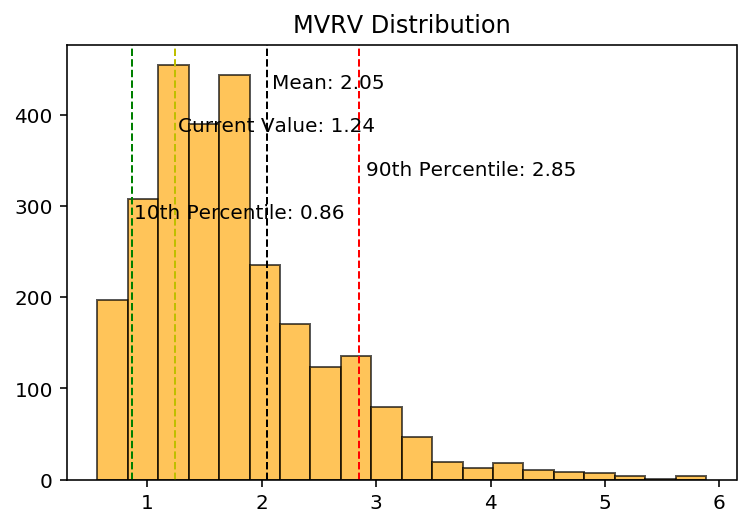

Current MVRV value is 1.24 and has a Z-Score of -0.26 compared to prior history


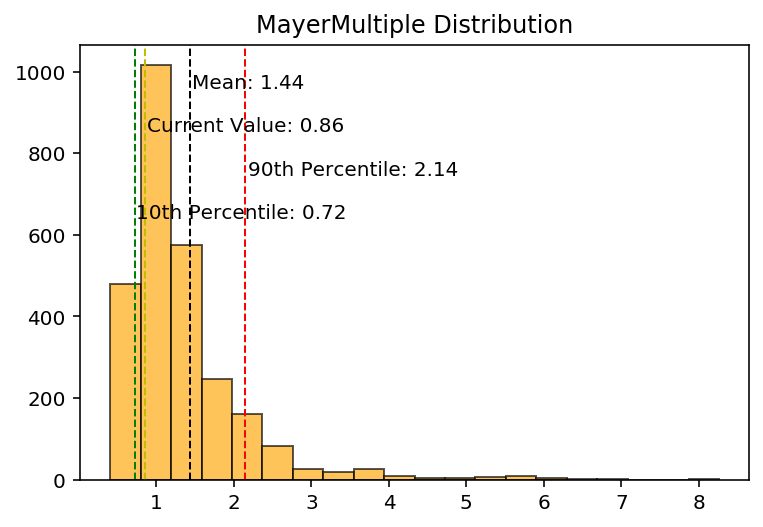

Current MayerMultiple value is 0.86 and has a Z-Score of -0.55 compared to prior history


In [13]:
# The final list of metrics we care about
final_metrics = [
    'NVTSRatioRoll90',
    'RVTRatioRoll28',
    'MVRV',
    'MayerMultiple'
]

for metric_name in final_metrics:
    # Calculate some descriptive statistics for this metric
    metric_current_value = np.array(data[metric_name])[-1]
    metric_mean = np.mean(data[metric_name])
    metric_stdev = np.std(data[metric_name])
    metric_current_z_score = (metric_current_value - metric_mean) / metric_stdev

    # Plot the histogram
    result = plt.hist(
        data.loc[data['date'] >= '2013-01-01'][metric_name], bins=20, color='orange', edgecolor='k', alpha=0.65)
    min_ylim, max_ylim = plt.ylim()
    # Chart title
    plt.title("{} Distribution".format(metric_name))
    
    # Plot line for metric mean on top of the histogram
    plt.axvline(metric_mean, color='k', linestyle='dashed', linewidth=1)
    plt.text(metric_mean * 1.02, max_ylim * 0.9, 'Mean: {:.2f}'.format(metric_mean))
    
    # Plot line for current value on top of the histogram
    plt.axvline(metric_current_value, color='y', linestyle='dashed', linewidth=1)
    plt.text(metric_current_value * 1.02, max_ylim * 0.8, 'Current Value: {:.2f}'.format(metric_current_value))
    
    # Plot 90th percentile on top of the histogram
    p90 = np.percentile(data.loc[data['date'] >= '2013-01-01'][metric_name].dropna(), 90)
    plt.axvline(
        p90,
        color='g' if 'RVT' in metric_name else 'r',
        linestyle='dashed', linewidth=1)
    plt.text(p90 * 1.02, max_ylim * 0.7, '90th Percentile: {:.2f}'.format(p90))
    
    # Plot 10th percentile on top of the histogram
    p10 = np.percentile(data.loc[data['date'] >= '2013-01-01'][metric_name].dropna(), 10)
    plt.axvline(
        p10,
        color='r' if 'RVT' in metric_name else 'g',
        linestyle='dashed', linewidth=1)
    plt.text(p10 * 1.02, max_ylim * 0.6, '10th Percentile: {:.2f}'.format(p10))
    
    plt.show()
    
    print("Current {} value is {:.2f} and has a Z-Score of {:.2f} compared to prior history".format(
        metric_name, metric_current_value, metric_current_z_score
    ))

These ratio values are clearly not normally distributed, so we should ignore the Z-scores, but we can still eyeball the distribution and make deductions about how extreme the current values are.

As of April 2020:
- All four of these data series are currently at moderate values (in middle 80% of distribution) so they do not have strong conviction in price mean reversion in either direction
- RVT, MVRV and MayerMultiple are indicating a potentially attractive time to buy BTC, compared to historical values, but signal is not strong
- NVTS is somewhat less sanguine and indicates the network value is slightly outpacing on-chain usage. However, usage of layer two and off-chain solutions has likely increased compared to the majority of the time period this metric is calibrated against, so it's hard to make strong conclusions in this regard.

# Final note

I am impressed if you made it this far. Thanks for following along and I hope you learned something.

If you enjoyed this tutorial you can follow me on twitter [@typerbole](https://twitter.com/typerbole), where I will continue to publish tutorials and Bitcoin data science content. Feel free to DM me with feedback or suggestions, or email me at [my twitter handle] at pm.me.